In [1]:
import scanpy as sc
import pandas as pd
import scipy as sp
from tqdm.notebook import tqdm
import numpy as np
import warnings

## Parameters for generating training data

In [2]:
train_m_per_ko = 8000 ## Increase for more "pairs of cells"
evenly_split_nc = False
train_val_test_ratio = (.8, .1, .1)
cell_train_val_test_ratio = (.6, .2, .2)
task_name = ('ko')
split_names = ('train', 'val', 'test')

assert sum(train_val_test_ratio) == 1., f"split ratio must sum up to 1"

val_m_per_ko = np.ceil(train_m_per_ko / train_val_test_ratio[0] * train_val_test_ratio[1]).astype(int)
test_m_per_ko = np.ceil(train_m_per_ko / train_val_test_ratio[0] * train_val_test_ratio[2]).astype(int)
print(f"KO-Ctrl per ko -- train: {train_m_per_ko}, val: {val_m_per_ko}, test: {test_m_per_ko}.")
ms_per_ko = (train_m_per_ko, val_m_per_ko, test_m_per_ko)

KO-Ctrl per ko -- train: 8000, val: 1000, test: 1000.


## Read in original data

Reading mtx is quite slow so it's a good idea to store it into a h5ad.

In [3]:
if False:
    adata = sc.AnnData(sc.read_mtx("GSE133344_filtered_matrix.mtx.gz").T)
    obs = pd.read_csv("GSE133344_filtered_barcodes.tsv.gz", index_col=0, header=None)
    obs.index.name = 'cell_barcode'
    adata.obs = obs
    # adata.var_names = pd.read_table("GSE133344_filtered_features.tsv.gz", index_col=0, header=None).index.tolist()
    
    var = pd.read_table("GSE133344_filtered_features.tsv.gz", index_col=0, header=None)
    var.columns = ['Gene Names']
    var.index.name = 'Gene ID'
    var
    adata.var = var
    
    obs2 = pd.read_csv("GSE133344_filtered_cell_identities.csv.gz", index_col=0)
    obs2
    
    columns = obs2.columns.tolist()
    columns[0] = 'task_' + columns[0]
    obs2.columns = columns
    
    adata = adata[obs2.index, :]
    adata.obs = obs2
    
    adata.write_h5ad("perturb_seq_norman.h5ad")
else:
    adata = sc.read_h5ad("perturb_seq_norman.h5ad")

adata

AnnData object with n_obs × n_vars = 111445 × 33694
    obs: 'task_guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells'
    var: 'Gene Names'

## Gather KO metadata

In [4]:
adata.obs['task_guide_identity'] = adata.obs['task_guide_identity'].str.split('__').str[0]

In [5]:
adata.obs['task_guide_identity'].value_counts()

task_guide_identity
NegCtrl10_NegCtrl0    3532
NegCtrl1_NegCtrl0     2948
NegCtrl11_NegCtrl0    2839
NegCtrl0_NegCtrl0     2536
CEBPE_RUNX1T1         1219
                      ... 
CBL_UBASH3A             64
CEBPB_CEBPA             64
JUN_CEBPB               59
C3orf72_FOXL2           59
JUN_CEBPA               54
Name: count, Length: 287, dtype: int64

In [6]:
adata.obs['task_guide_identity_one'] = adata.obs['task_guide_identity'].str.split('_').str[0]
adata.obs['task_guide_identity_other'] = adata.obs['task_guide_identity'].str.split('_').str[1]

In [7]:
task_guides = sorted(list(set(adata.obs['task_guide_identity_one'].tolist() + adata.obs['task_guide_identity_other'].tolist())))
len(task_guides)

109

In [8]:
guide_df = pd.DataFrame(0, index=task_guides, columns=task_guides)
for i, j in zip(adata.obs['task_guide_identity_one'], adata.obs['task_guide_identity_other']):
    guide_df.loc[i, j] += 1

In [9]:
guide_df.style

,AHR,ARID1A,ARRDC3,ATL1,BAK1,BCL2L11,BCORL1,BPGM,C19orf26,C3orf72,CBFA2T3,CBL,CDKN1A,CDKN1B,CDKN1C,CEBPA,CEBPB,CEBPE,CELF2,CITED1,CKS1B,CLDN6,CNN1,CNNM4,COL1A1,COL2A1,CSRNP1,DLX2,DUSP9,EGR1,ELMSAN1,ETS2,FEV,FOSB,FOXA1,FOXA3,FOXF1,FOXL2,FOXO4,GLB1L2,HES7,HK2,HNF4A,HOXA13,HOXB9,HOXC13,IER5L,IGDCC3,IKZF3,IRF1,ISL2,JUN,KIAA1804,KIF18B,KIF2C,KLF1,KMT2A,LHX1,LYL1,MAML2,MAP2K3,MAP2K6,MAP4K3,MAP4K5,MAP7D1,MAPK1,MEIS1,MIDN,NCL,NIT1,NegCtrl0,NegCtrl1,NegCtrl10,NegCtrl11,OSR2,PLK4,POU3F2,PRDM1,PRTG,PTPN1,PTPN12,PTPN13,PTPN9,RHOXF2,RREB1,RUNX1T1,S1PR2,SAMD1,SET,SGK1,SLC38A2,SLC4A1,SLC6A9,SNAI1,SPI1,STIL,TBX2,TBX3,TGFBR2,TMSB4X,TP73,TSC22D1,UBASH3A,UBASH3B,ZBTB1,ZBTB10,ZBTB25,ZC3HAV1,ZNF318
AHR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ARID1A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ARRDC3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ATL1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,379,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BAK1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BCL2L11,0,0,0,0,175,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,463,0,0,0,0,0,0,0,0,0,0
BCORL1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BPGM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,358,0,0,0,0
C19orf26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C3orf72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
adata.obs['nko'] = ((~adata.obs['task_guide_identity_one'].str.contains('NegCtrl')).astype(int) + 
                    (~adata.obs['task_guide_identity_other'].str.contains('NegCtrl')).astype(int))

In [11]:
adata.obs['nko'].value_counts()

nko
1    57831
2    41759
0    11855
Name: count, dtype: int64

In [12]:
adata.obs['ko'] = ''
adata.obs.loc[adata.obs['nko'] == 0, 'ko'] = 'NegCtrl'
adata.obs.loc[adata.obs['nko'] == 2, 'ko'] = 'Double'
one_nc = adata.obs['task_guide_identity_one'].str.contains('NegCtrl')
other_nc = adata.obs['task_guide_identity_other'].str.contains('NegCtrl')
adata.obs.loc[one_nc & ~other_nc, 'ko'] = adata.obs.loc[one_nc & ~other_nc, 'task_guide_identity_other']
adata.obs.loc[~one_nc & other_nc, 'ko'] = adata.obs.loc[~one_nc & other_nc, 'task_guide_identity_one']
adata.obs.loc[~one_nc & ~other_nc, 'ko'] = adata.obs.loc[~one_nc & ~other_nc, 'task_guide_identity_one'] + '|' + adata.obs.loc[~one_nc & ~other_nc, 'task_guide_identity_other']

In [13]:
adata.obs['ko'].value_counts()

ko
NegCtrl          11855
KLF1              1960
BAK1              1457
CEBPE             1233
CEBPE|RUNX1T1     1219
                 ...  
CBL|UBASH3A         64
CEBPB|CEBPA         64
C3orf72|FOXL2       59
JUN|CEBPB           59
JUN|CEBPA           54
Name: count, Length: 237, dtype: int64

In [14]:
adata.obs['ko'].unique()

array(['ARID1A', 'BCORL1', 'FOSB', 'SET|KLF1', 'OSR2', 'KLF1|BAK1',
       'FOXA3|FOXL2', 'TP73', 'HES7', 'IRF1|SET', 'IGDCC3|MAPK1',
       'UBASH3B', 'CBL|PTPN12', 'MAP2K6', 'SAMD1|PTPN12', 'BCL2L11',
       'UBASH3A', 'LYL1|IER5L', 'CDKN1C|CDKN1A', 'AHR|FEV', 'LHX1',
       'FOXA3', 'SGK1|TBX3', 'C3orf72|FOXL2', 'TGFBR2|PRTG', 'CDKN1A',
       'HOXB9', 'CDKN1C|CDKN1B', 'NegCtrl', 'CSRNP1', 'ISL2',
       'MAP2K3|MAP2K6', 'CDKN1C', 'MAP7D1', 'CBL|TGFBR2', 'MAPK1|IKZF3',
       'PTPN12|SNAI1', 'LHX1|ELMSAN1', 'FOXA3|FOXF1', 'CDKN1B',
       'CEBPB|PTPN12', 'PTPN1', 'ZBTB25', 'MAPK1|PRTG', 'SET',
       'MAP2K3|IKZF3', 'DUSP9|PRTG', 'SLC4A1', 'KLF1|COL2A1',
       'KLF1|CLDN6', 'KLF1|TGFBR2', 'STIL', 'CNN1', 'SAMD1', 'MAML2',
       'ZBTB10|SNAI1', 'KLF1|MAP2K6', 'BAK1', 'ZC3HAV1|HOXC13', 'IER5L',
       'DLX2', 'RREB1', 'CELF2', 'HNF4A', 'ETS2', 'CBL|PTPN9', 'COL1A1',
       'SLC6A9', 'KIF18B|KIF2C', 'CEBPE|RUNX1T1', 'PTPN9', 'FOSB|UBASH3B',
       'MAP2K3|ELMSAN1', 'ETS2|MAP7D1', 'TB

In [15]:
## Any ko in different orders? i.e., A|B and B|A both show up?
double_ko_ordered = []
has_dup = False
for i in adata.obs['ko'].unique():
    if '|' in i:
        i, j = i.split('|')
        if i > j:
            i, j = j, i
        if (i, j) in double_ko_ordered:
            has_dup = True
            print(i, j)
        else:
            double_ko_ordered.append((i, j))

if has_dup:
    print("Duplicates found.")
else:
    print("No duplicates.")

No duplicates.


In [16]:
## Any KO in double KOs doesn't show up as a single KO?
single_kos = []
for i in adata.obs['ko'].unique():
    if '|' not in i:
        single_kos.append(i)

has_novel = False
for i in adata.obs['ko'].unique():
    if '|' in i:
        i, j = i.split('|')
        for i in i, j:
            if i not in single_kos:
                has_novel = True
                print(i)

if has_novel:
    print("Novel ko in double kos found.")
else:
    print("No novel ko. All good.")

No novel ko. All good.


In [17]:
## which ko shows up in double kos?
double_ko_cnt = {}
double_kos = []
for i in adata.obs['ko'].unique():
    if '|' in i:
        double_kos.append(i)
        i, j = i.split('|')
        double_ko_cnt[i] = double_ko_cnt.get(i, 0) + 1
        double_ko_cnt[j] = double_ko_cnt.get(j, 0) + 1
double_ko_cnt = pd.Series(double_ko_cnt).sort_values(ascending=False)
double_ko_cnt

PTPN12     12
KLF1       11
CEBPE      11
UBASH3B    10
TGFBR2      9
           ..
LHX1        1
C3orf72     1
IER5L       1
IRF1        1
PRDM1       1
Length: 73, dtype: int64

In [18]:
adata

AnnData object with n_obs × n_vars = 111445 × 33694
    obs: 'task_guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'task_guide_identity_one', 'task_guide_identity_other', 'nko', 'ko'
    var: 'Gene Names'

## Split data

Acutal KOs are split by `train_val_test_ratio`. Negative controls are split evenly.

In [19]:
np.random.seed(0)
indices = [[] for i in range(len(cell_train_val_test_ratio))]
kos = adata.obs['ko'].value_counts()
for ko in kos.index:
    n = kos.loc[ko]
    pool = adata.obs_names[adata.obs['ko'] == ko].to_numpy()
    np.random.shuffle(pool)
    if ko == 'NegCtrl' and evenly_split_nc:
        ratio = [1 / len(cell_train_val_test_ratio)] * len(cell_train_val_test_ratio)
    else:
        ratio = cell_train_val_test_ratio
    l = 0
    for i, r in enumerate(ratio):
        r = min(l + np.round(r * n).astype(int), n)
        assert r > l, f"Zero sized class. Too few samples (n = {n}) or too small split ratio?"
        indices[i].extend(pool[l:r])
        l = r

In [20]:
ko2int = {}
cnt = 1
cnt2 = -2
for i in kos.index:
    if i == 'NegCtrl':
        ko2int[i] = -1
    elif i in single_kos:
        ko2int[i] = cnt
        cnt += 1
    else:
        ko2int[i] = cnt2
        cnt2 -= 1
adata.obs['ko_int'] = adata.obs['ko'].apply(ko2int.get)

In [21]:
adata.obs['ko_int']

cell_barcode
TTGAACGAGACTCGGA-2     98
CGTTGGGGTGTTTGTG-7     50
GAACCTAAGTGTTAGA-6     37
CCTTCCCTCCGTCATC-4     -7
TCAATCTGTCTTTCAT-2      6
                     ... 
TTTGCGCAGTCATGCT-2     80
TTTGCGCCAGGACCCT-3   -108
TTTGCGCGTACTTGAC-3     17
TTTGCGCTCTCGCATC-6    -94
TTTGGTTGTTCCGTCT-2    -13
Name: ko_int, Length: 111445, dtype: int64

In [22]:
obss = [adata.obs.loc[i].copy() for i in indices]

In [23]:
for obs in obss:
    print(obs.shape)

(66874, 12)
(22288, 12)
(22240, 12)


In [24]:
ind2iloc = {v: i for i, v in enumerate(adata.obs_names)}

In [25]:
## You won't want this to be greater than 1%.
print("density:", f"{train_m_per_ko * len(kos) / len(indices[0]) ** 2 * 100:.2f}%")

density: 0.04%


## Generate pairs

In [26]:
def random_pairs(x, y, n):
    ind = np.random.choice(x * y, n, replace=False)
    return np.stack((ind // y, ind % y))

random_pairs(2, 3, 6)

array([[1, 0, 0, 1, 0, 1],
       [1, 1, 0, 2, 2, 0]], dtype=int32)

In [27]:
## So here's the plan:
totals = []
for split_name, obs, m in zip(split_names, obss, ms_per_ko):
    total = 0
    d, c, r = [], [], []
    nc_indices = obs.index[obs['ko_int'] == -1]
    for i in tqdm(ko2int):
        if ko2int[i] < -1:
            continue
        # single ko: i vs nc
        ko_indices = obs.index[obs['ko_int'] == ko2int[i]]
        single_ko_cnt = len(ko_indices)
        # double ko: i|j or j|i vs j
        other_ko = []
        both_kos = []
        for k in double_kos:
            ko1, ko2 = k.split('|')
            if i == ko1:
                other_ko.append(ko2)
                both_kos.append(k)
            elif i == ko2:
                other_ko.append(ko1)
                both_kos.append(k)
        # other_ko_cnt = []
        # for j in other_ko:
            # other_ko_cnt.append((obs['ko_int'] == ko2int[j]).sum())
        other_ko_m = m // (len(other_ko) + 1) 
        single_ko_m = m - other_ko_m * len(other_ko)
        for j, ij in zip(other_ko, both_kos):
            new_nc_indicies = obs.index[obs['ko_int'] == ko2int[j]]
            new_ko_indicies = obs.index[obs['ko_int'] == ko2int[ij]]
            if len(new_nc_indicies) * len(new_ko_indicies) < other_ko_m:
                actual_m = len(new_nc_indicies) * len(new_ko_indicies)
                warnings.warn(f"{ij} - {j}: {actual_m} < {other_ko_m}")
            else:
                actual_m = other_ko_m
            cc, rr = random_pairs(len(new_nc_indicies), len(new_ko_indicies), actual_m)
            cc = new_nc_indicies[cc].to_series().apply(ind2iloc.get).tolist()
            rr = new_ko_indicies[rr].to_series().apply(ind2iloc.get).tolist()
            c.extend(cc)
            r.extend(rr)
            d.extend([ko2int[i]] * actual_m)
            total += actual_m
            
        new_nc_indicies = ko_indices
        new_ko_indicies = obs.index[obs['ko_int'] == ko2int[i]]
        if len(new_nc_indicies) * len(new_ko_indicies) < single_ko_m:
            actual_m = len(new_nc_indicies) * len(new_ko_indicies)
            warnings.warn(f"{i}: {actual_m} < {single_ko_m}")
        else:
            actual_m = single_ko_m
        cc, rr = random_pairs(len(new_nc_indicies), len(new_ko_indicies), actual_m)
        cc = new_nc_indicies[cc].to_series().apply(ind2iloc.get).tolist()
        rr = new_ko_indicies[rr].to_series().apply(ind2iloc.get).tolist()
        c.extend(cc)
        r.extend(rr)
        d.extend([ko2int[i]] * actual_m)
        total += actual_m
    adata.obsp[f'task_{task_name}_{split_name}'] = sp.sparse.csc_matrix((d, (r, c)), shape=(adata.shape[0], adata.shape[0]))
    totals.append(total)

  0%|          | 0/237 [00:00<?, ?it/s]

C:\Users\lshh\AppData\Local\Temp\ipykernel_93568\2661542733.py:34: UserWarning: PLK4|STIL - PLK4: 3332 < 4000
  warnings.warn(f"{ij} - {j}: {actual_m} < {other_ko_m}")
C:\Users\lshh\AppData\Local\Temp\ipykernel_93568\2661542733.py:49: UserWarning: HES7: 5776 < 8000
  warnings.warn(f"{i}: {actual_m} < {single_ko_m}")


  0%|          | 0/237 [00:00<?, ?it/s]

C:\Users\lshh\AppData\Local\Temp\ipykernel_93568\2661542733.py:34: UserWarning: PLK4|STIL - PLK4: 368 < 500
  warnings.warn(f"{ij} - {j}: {actual_m} < {other_ko_m}")
C:\Users\lshh\AppData\Local\Temp\ipykernel_93568\2661542733.py:49: UserWarning: HES7: 625 < 1000
  warnings.warn(f"{i}: {actual_m} < {single_ko_m}")


  0%|          | 0/237 [00:00<?, ?it/s]

C:\Users\lshh\AppData\Local\Temp\ipykernel_93568\2661542733.py:34: UserWarning: PLK4|STIL - PLK4: 352 < 500
  warnings.warn(f"{ij} - {j}: {actual_m} < {other_ko_m}")
C:\Users\lshh\AppData\Local\Temp\ipykernel_93568\2661542733.py:49: UserWarning: PLK4: 484 < 500
  warnings.warn(f"{i}: {actual_m} < {single_ko_m}")


In [28]:
adata.obs['train_val_test'] = ''
for split_name, obs in zip(split_names, obss):
    adata.obs.loc[obs.index, 'train_val_test'] = split_name

## Sanity checks / unit tests

In [29]:
totals

[845108, 105493, 105461]

In [30]:
adata.obsp['task_ko_train'].size

845108

In [31]:
for i, j in zip(adata.obsp.values(), totals):
    assert i.size == j, "Numbers of non-zero elements in obsp aren't as specified. The code generating pairs is wrong. Duplicate pairs?"

In [32]:
rows = []
cols = []
for i in adata.obsp.values():
    rows.append((i != 0).sum(axis=1) > 0)
    cols.append((i != 0).sum(axis=0) > 0)

assert not np.any(sum(rows) > 1), "Some KOs are shared among splits. The code generating pairs is wrong."
assert not np.any(sum(cols) > 1), "NC are shared among splits. The code generating pairs is wrong."

In [33]:
adata.obs

,task_guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,task_guide_identity_one,task_guide_identity_other,nko,ko,ko_int,train_val_test
cell_barcode,,,,,,,,,,,,,
TTGAACGAGACTCGGA-2,ARID1A_NegCtrl0,28684,1809,15.856274,2,True,1,ARID1A,NegCtrl0,1,ARID1A,98,train
CGTTGGGGTGTTTGTG-7,BCORL1_NegCtrl0,18367,896,20.498884,7,True,1,BCORL1,NegCtrl0,1,BCORL1,50,train
GAACCTAAGTGTTAGA-6,FOSB_NegCtrl0,16296,664,24.542169,6,True,1,FOSB,NegCtrl0,1,FOSB,37,train
CCTTCCCTCCGTCATC-4,SET_KLF1,16262,850,19.131765,4,True,1,SET,KLF1,2,SET|KLF1,-7,val
TCAATCTGTCTTTCAT-2,OSR2_NegCtrl0,16057,1067,15.048735,2,True,2,OSR2,NegCtrl0,1,OSR2,6,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCAGTCATGCT-2,RHOXF2_NegCtrl0,1,1,1.000000,2,False,0,RHOXF2,NegCtrl0,1,RHOXF2,80,val
TTTGCGCCAGGACCCT-3,BCL2L11_BAK1,1,1,1.000000,3,False,0,BCL2L11,BAK1,2,BCL2L11|BAK1,-108,train
TTTGCGCGTACTTGAC-3,CNN1_NegCtrl0,1,1,1.000000,3,False,0,CNN1,NegCtrl0,1,CNN1,17,test


In [34]:
for i in ko2int.values():
    if i >= -1:
        print((adata.obsp['task_ko_train'] == i).sum())

for i in ko2int.values():
    if i >= -1:
        print((adata.obsp['task_ko_val'] == i).sum())

for i in ko2int.values():
    if i >= -1:
        print((adata.obsp['task_ko_test'] == i).sum())

8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
7332
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
5776
8000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
868
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1

In [53]:
n_classes = (np.array(list(ko2int.values())) > 0).sum()
task_order = [''] * (n_classes + 1)
for i, v in ko2int.items():
    if v > 0:
        assert task_order[v] == ''
        task_order[v] = i
task_order.append("NegCtrl")

adata.uns['task_order'] = np.array(task_order)
adata.uns['task_order']

array(['', 'KLF1', 'BAK1', 'CEBPE', 'UBASH3B', 'ETS2', 'OSR2', 'SLC4A1',
       'SET', 'ELMSAN1', 'MAP2K6', 'FOXF1', 'C19orf26', 'FOXA1',
       'UBASH3A', 'RUNX1T1', 'MEIS1', 'CNN1', 'MAPK1', 'MAP7D1', 'ZBTB25',
       'DLX2', 'DUSP9', 'FEV', 'HOXB9', 'ZBTB1', 'TBX3', 'TBX2', 'PRTG',
       'IKZF3', 'CLDN6', 'CBL', 'CBFA2T3', 'FOXL2', 'ZNF318', 'TGFBR2',
       'KIF2C', 'FOSB', 'MAML2', 'SPI1', 'IGDCC3', 'COL2A1', 'BCL2L11',
       'ISL2', 'MAP2K3', 'SLC6A9', 'AHR', 'CDKN1B', 'TMSB4X', 'S1PR2',
       'BCORL1', 'ZC3HAV1', 'SAMD1', 'ARRDC3', 'FOXA3', 'CEBPB', 'SGK1',
       'CSRNP1', 'CELF2', 'CNNM4', 'SNAI1', 'BPGM', 'GLB1L2', 'CEBPA',
       'PTPN9', 'PTPN12', 'TSC22D1', 'LYL1', 'IRF1', 'PTPN1', 'IER5L',
       'HOXC13', 'ATL1', 'LHX1', 'MAP4K5', 'MAP4K3', 'CDKN1A', 'POU3F2',
       'SLC38A2', 'RREB1', 'RHOXF2', 'COL1A1', 'EGR1', 'STIL', 'HK2',
       'MIDN', 'PRDM1', 'KIAA1804', 'HOXA13', 'PTPN13', 'JUN', 'C3orf72',
       'KIF18B', 'TP73', 'CKS1B', 'KMT2A', 'NCL', 'HNF4A', 'ARID1A'

In [54]:
adata.obsp['task_ko_train'][adata.obsp['task_ko_train'] == -1] = n_classes + 1
adata.obsp['task_ko_val'][adata.obsp['task_ko_val'] == -1] = n_classes + 1
adata.obsp['task_ko_test'][adata.obsp['task_ko_test'] == -1] = n_classes + 1

In [55]:
adata.obsp['task_ko'] = adata.obsp['task_ko_train'] + adata.obsp['task_ko_val'] + adata.obsp['task_ko_test']
adata.obsp['train'] = adata.obsp['task_ko_train'] != 0
adata.obsp['val'] = adata.obsp['task_ko_val'] != 0
adata.obsp['test'] = adata.obsp['task_ko_test'] != 0

In [63]:
assert (adata.obsp['train'] * adata.obsp['val']).sum() == 0
assert (adata.obsp['test'] * adata.obsp['val']).sum() == 0
assert (adata.obsp['train'] * adata.obsp['test']).sum() == 0

assert (adata.obsp['task_ko_train'] < 0).sum() == 0
assert (adata.obsp['task_ko_val'] < 0).sum() == 0
assert (adata.obsp['task_ko_test'] < 0).sum() == 0

assert (adata.obsp['task_ko']).max() == n_classes + 1

In [57]:
adata.write_h5ad("perturb_seq_norman_diff_ko_paired.h5ad")

## EDA: How hard is the task?

In [36]:
# adata = sc.read_h5ad("perturb_seq_norman_1ko_paired.h5ad", genome='X')
adata.X.max()

3718.0

In [37]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [38]:
adata = adata[:, adata.var['highly_variable']]

In [39]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\preprocessing\_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to Tru

In [40]:
adata.obs['NegCtrl'] = (adata.obs['ko'] == 'NegCtrl') + 0

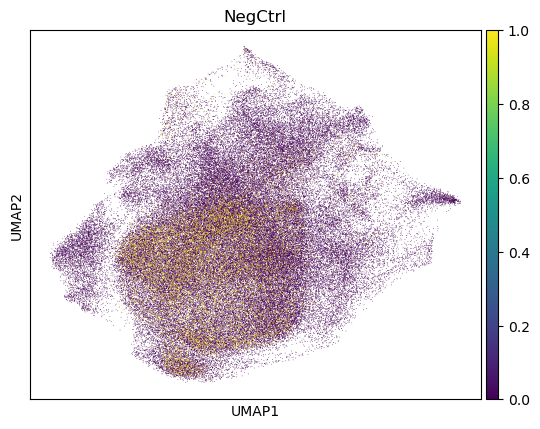

In [41]:
sc.pl.umap(adata, color="NegCtrl")